# Assignment 03
210218M  Herath H.M.S.I.\
Github Link = [https://github.com/sandun21/Image-Processing-and-Computer-Vision](https://github.com/sandun21/Image-Processing-and-Computer-Vision)

## Question 01 - BackPropogation

100%|██████████| 170M/170M [00:01<00:00, 101MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1 / 10, Loss: 2.0367001304626466
Epoch 2 / 10, Loss: 1.7779689328670503
Epoch 3 / 10, Loss: 1.6944028103351594
Epoch 4 / 10, Loss: 1.638452102780342
Epoch 5 / 10, Loss: 1.5909206157922744
Epoch 6 / 10, Loss: 1.5462028712034226
Epoch 7 / 10, Loss: 1.50437462079525
Epoch 8 / 10, Loss: 1.466547284603119
Epoch 9 / 10, Loss: 1.4336376521587373
Epoch 10 / 10, Loss: 1.4015003124475478


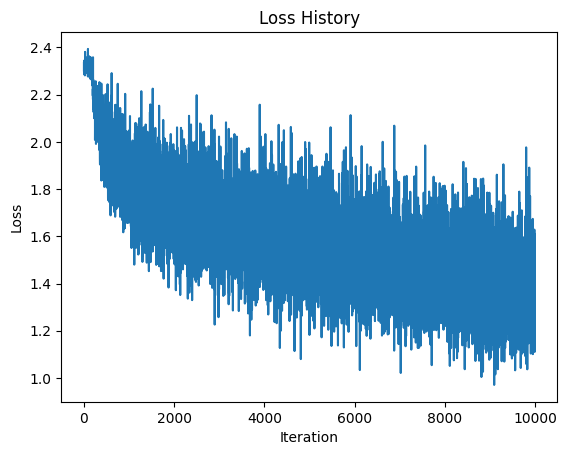

Training accuracy: 53.18%
Test accuracy: 47.69%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
Dhidden = 100
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, Dhidden) * std  # One layer: directly map input to output
b1 = torch.zeros(Dhidden)

w2 = torch.randn(Dhidden, K) * std  # One layer: directly map input to output
b2 = torch.zeros(K)

# Hyperparameters
iterations = 10
lr = 2e-3  # Learning rate
lr_decay = 0.99  # Learning rate decay
reg = 0  # Regularization
loss_history = []


cross_entropy_loss = lambda y_pred, y_true: nn.CrossEntropyLoss()(y_pred, y_true)

# Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        hl1 = x_train.mm(w1) + b1
        hl = torch.sigmoid(hl1)
        y_pred = hl.mm(w2) + b2            # Output layer activation # Raw logits


        # Loss calculation
        loss = cross_entropy_loss(y_pred, labels)
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred_as = nn.functional.softmax(y_pred, dim=1) - y_train_onehot  #Cross Entropy Derivative

        dw2 = hl.t().mm(dy_pred_as)
        db2 = dy_pred_as.sum(dim=0)

        z = dy_pred_as.mm(w2.t())
        dz = z * hl * (1 - hl)  # Derivative of sigmoid
        dw1 = x_train.t().mm(dz)
        db1 = dz.sum(dim=0)

        # Parameter update
        w2 -= lr * dw2
        b2 -= lr * db2

        w1 -= lr * dw1
        b1 -= lr * db1

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        hl1 = x_train.mm(w1) + b1
        hl = nn.functional.sigmoid(hl1)  # Output layer activation
        hl2 = hl.mm(w2) + b2
        y_train_pred = nn.functional.softmax(hl2, dim=1)

        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        hl1 = x_test.mm(w1) + b1
        hl = nn.functional.sigmoid(hl1)  # Output layer activation
        hl2 = hl.mm(w2) + b2
        y_test_pred = nn.functional.softmax(hl2, dim=1)

        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

## Question 02 - LeNet5 for MNIST

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets


device = torch.device("cpu")

# Setup training data
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=transforms.ToTensor()
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

# Implemented LeNet
class LeNet(nn.Module):
    """
    LeNet-inspired architecture.
    """
    def __init__(self, input_shape=1, hidden_units=6, output_shape=10):
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        self.output_shape = output_shape
        super(LeNet, self).__init__()
        # First convolutional block
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_units, kernel_size=5, stride=1, padding=2),  # 5x5 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling
        )
        # Second convolutional block
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 2 * 7 * 7, 120),  # Adjusted for 7x7 spatial dimensions post-pooling
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


# Model, Loss, and Optimizer
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')

# Test the Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1, Loss: 2.1986, Training Accuracy: 25.90%
Epoch 2, Loss: 0.4793, Training Accuracy: 85.34%
Epoch 3, Loss: 0.2195, Training Accuracy: 93.34%
Epoch 4, Loss: 0.1489, Training Accuracy: 95.46%
Epoch 5, Loss: 0.1174, Training Accuracy: 96.40%
Epoch 6, Loss: 0.1000, Training Accuracy: 96.91%
Epoch 7, Loss: 0.0874, Training Accuracy: 97.32%
Epoch 8, Loss: 0.0787, Training Accuracy: 97.57%
Epoch 9, Loss: 0.0723, Training Accuracy: 97.72%
Epoch 10, Loss: 0.0660, Training Accuracy: 97.97%
Test Accuracy: 97.75%


In [5]:
model

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=588, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

## Question 03 - Transfer Learning

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import time, os, torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode
%matplotlib inline

In [7]:
from urllib.request import urlretrieve
import zipfile

data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

zip_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
zip_file_path = os.path.join(data_dir, 'hymenoptera_data.zip')

if not os.path.exists(zip_file_path):
    urlretrieve(zip_url, zip_file_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print(f"Data extracted to: {data_dir}")

Data extracted to: data


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Epoch 0/24
----------
train Loss: 0.6175 Acc: 0.6803
val Loss: 0.3819 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.5318 Acc: 0.7869
val Loss: 0.2971 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4322 Acc: 0.7910
val Loss: 0.3343 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5062 Acc: 0.8115
val Loss: 0.3893 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5429 Acc: 0.7951
val Loss: 0.3676 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4940 Acc: 0.8402
val Loss: 0.3285 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4437 Acc: 0.8525
val Loss: 0.2386 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3386 Acc: 0.8689
val Loss: 0.1880 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3104 Acc: 0.8607
val Loss: 0.2498 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.2816 Acc: 0.8730
val Loss: 0.1666 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2813 Acc: 0.8689
val Loss: 0.1915 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2869 Acc: 0.8770
val Loss: 0.1845 Acc: 0.9346

Ep

### As a Feature Extractor

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5934 Acc: 0.6721
val Loss: 0.3527 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.4250 Acc: 0.8279
val Loss: 0.2643 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5859 Acc: 0.7623
val Loss: 0.2364 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5515 Acc: 0.7705
val Loss: 0.3473 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.4955 Acc: 0.7869
val Loss: 0.3068 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4739 Acc: 0.7992
val Loss: 0.3365 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4280 Acc: 0.8279
val Loss: 0.2051 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3737 Acc: 0.8361
val Loss: 0.2206 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3272 Acc: 0.8770
val Loss: 0.2189 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3398 Acc: 0.8525
val Loss: 0.2093 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4047 Acc: 0.8115
val Loss: 0.2064 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3164 Acc: 0.8648
val Loss: 0.1956 Acc: 0.9346

Ep

Both methods achieved high accuracy on the validation set:


- **Fine-Tuning:** The model reached an accuracy of approximately 92%.

- **Feature Extraction:** The model achieved an accuracy of around 95%.

These results show that both fine-tuning and feature extraction are effective strategies for transfer learning with the ResNet-18 model on the Hymenoptera dataset.\
\
Feature extraction outperforms fine-tuning in here because freezing most of the network prevents overfitting on the small dataset and improving generalization. Also, training only the final layer reduces training time.

